In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# Define the class labels
class_labels = [
    'actinic keratosis',
    'basal cell carcinoma',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pigmented benign keratosis',
    'seborrheic keratosis',
    'squamous cell carcinoma',
    'vascular lesion'
]

In [ ]:
train_data_path = 'content/drive/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'  # Replace with your training data directory path
test_data_path = 'content/drive/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'     # Replace with your testing data directory path


In [ ]:
# Set up image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set aside 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='validation'
)

# Load test data
test_data = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [ ]:
# Create a label encoder
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Assuming train_data has been defined previously
labels = train_data.classes  # Get the class indices from your training data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert class weights to a dictionary format
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


In [ ]:
# Load pre-trained DenseNet model without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(9, activation='softmax')(x)  # Use the number of classes defined above

# Create the new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
# Compile the model using the Adam optimizer
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, 156, 156,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 11,234,377 (42.86 MB)

 Trainable params: 4,196,873 (16.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.1949 - loss: 4.5811 - val_accuracy: 0.3986 - val_loss: 1.8995 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.3591 - loss: 1.6655 - val_accuracy: 0.3941 - val_loss: 1.7992 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4513 - loss: 1.4437 - val_accuracy: 0.4212 - val_loss: 1.6960 - learning_rate: 0.0010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4775 - loss: 1.3194 - val_accuracy: 0.4572 - val_loss: 1.6051 - learning_rate: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4897 - loss: 1.3138 - val_accuracy: 0.4572 - val_loss: 1.7602 - learning_rate: 0.0010
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5217 - loss: 1.2081 - val_accuracy: 0.4640 - val_loss: 1.7498 - learning_rate: 0.0010
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5404 - loss: 1.1706 - val_accuracy: 0.4505 - 

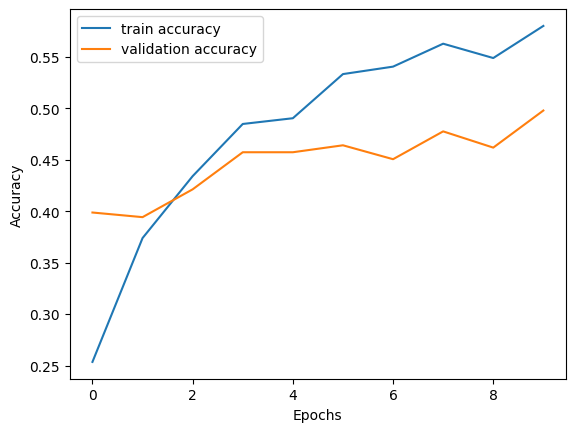

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


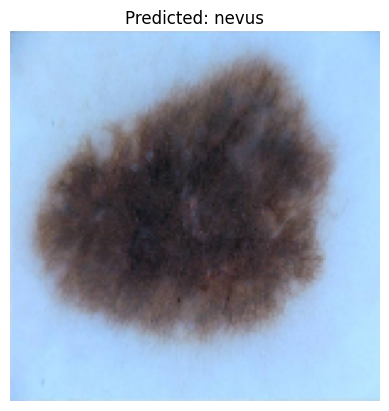

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
def classify_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))  # Load the image
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# Example usage: classify an image
classify_image('content/drive/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


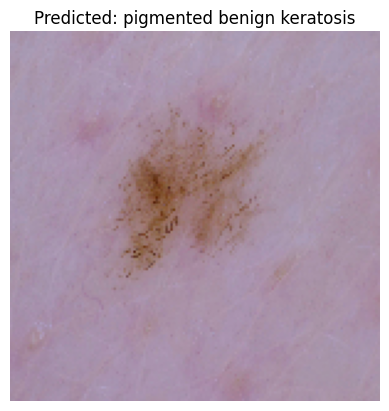

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
def classify_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))  # Load the image
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# Example usage: classify an image
classify_image('content/drive/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024324.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Disease detected! Affected area: 5.80%


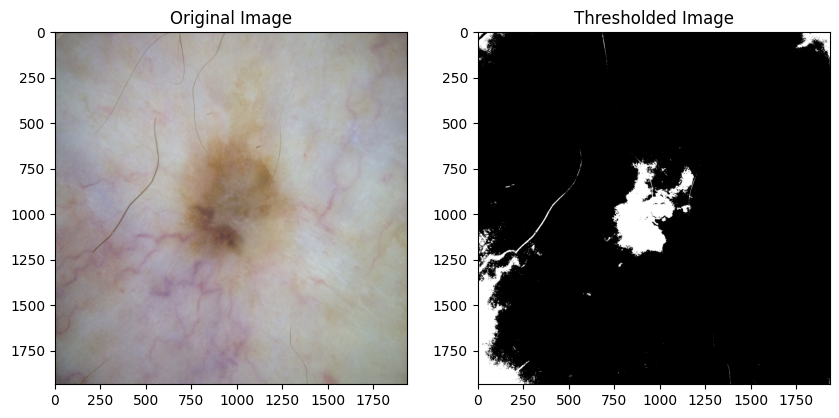

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calculate_disease_percentage(image_path):
    # Load image
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (150, 150))  # Resize to model input size
    image_resized = image_resized / 255.0  # Normalize

    # Predict whether the image contains disease or not
    image_input = np.expand_dims(image_resized, axis=0)
    predictions = model.predict(image_input)

    # Assuming 'vascular lesion' is the last class in your class_labels
    disease_class_index = class_labels.index('vascular lesion')  # Change if necessary
    disease_probability = predictions[0][disease_class_index]  # Get the probability for the 'vascular lesion' class

    if disease_probability > 0.5:  # Disease present
        # Convert to grayscale and threshold the image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

        # Calculate percentage of disease-affected area
        total_pixels = image.shape[0] * image.shape[1]
        disease_pixels = np.sum(thresholded_image == 255)
        disease_percentage = (disease_pixels / total_pixels) * 100

        print(f"Disease detected! Affected area: {disease_percentage:.2f}%")

        # Show original and thresholded images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.subplot(1, 2, 2)
        plt.imshow(thresholded_image, cmap='gray')
        plt.title("Thresholded Image")
        plt.show()
    else:
        print("No disease detected.")

# Test the model on a new image
image_path = 'content/drive/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/dermatofibroma/ISIC_0001114.jpg'  # Replace with your test image path
calculate_disease_percentage(image_path)
